In [41]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio


In [42]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
from torchmetrics.classification import BinaryAUROC


print("Torch version:", torch.__version__)


Torch version: 1.13.0+cu117


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
# !unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/


In [45]:
!mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations,features/{train,test,val}}
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/


### Load Hateful Meme Dataset

In [46]:
import os

HOME = os.environ.get("HOME")
images_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/"
)
annotations_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"
)
features_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/features/"
)


In [47]:
import pandas as pd

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

In [48]:
train.head()


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [49]:
# # Collect all the annotations (from Phase-2)
# train       = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
# dev_seen    = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
# dev_unseen  = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
# test_seen   = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
# test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

# Create 2 sets:
#   A set of strings, 'a': for all the image names,
#   A set of lists, 'b': for all the image names in dataset, e.g. train, dev_seen, etc.
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ["train", "dev_seen", "dev_unseen", "test_seen", "test_unseen"]
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(
        f"\nIn total there are {total_size} images,",
        "\nBut the # of images in /img/ directory is: ",
        len(a),
    )


#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /img/ directory is:  12469


In [50]:
print(
    "#of images that are not in one of the .jsonl files: ",
    len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))),
)


#of images that are not in one of the .jsonl files:  329


In [51]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(
                f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}"
            )


#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [52]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(
    f"{annotations_path}/train_updated.jsonl", orient="records", lines=True
)
train.shape, train_updated.shape


((8500, 4), (8600, 4))

## Write the dataset class

In [53]:
train.head(1)


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters


In [54]:
class HMDataset(Dataset):
    def __init__(
        self,
        images_path: str,
        annotation_path: str,
        features_path=None,
        feature_names_dict: dict = None,
        image_transform=None,
        text_transform=None,
    ) -> None:

        # Try to load features if previously saved and requested. If not saved, fall back to
        self.features_path = features_path
        self.feature_names_dict = feature_names_dict
        # self.images_features, self.text_features, self.labels = None, None, None
        if self.features_path:
            if not self.feature_names_dict:
                self.feature_names_dict = {
                    "image_features": "image_features.pt",
                    "text_features": "text_features.pt",
                    "label_features": "label_features.pt",
                }
                
            try:
                self.images_features = torch.load(f"{features_path}/{self.feature_names_dict['image_features']}")
                self.text_features = torch.load(f"{features_path}/{self.feature_names_dict['text_features']}")
                self.labels = torch.load(f"{features_path}/{self.feature_names_dict['label_features']}")
                return
            except FileNotFoundError as e:
                print(
                    "Unable to load fused_images_and_texts and/or labels from the paths provided. "
                    f"Falling back to loading actual datasets {e}"
                )

        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(
            ".jsonl"
        ), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)

    def __len__(self):
        if hasattr(self, "labels"):
            return self.labels.shape[0]

        return self.annotation.shape[0]

    def __getitem__(self, index):
        if hasattr(self, "images_features") and hasattr(self, "text_features") and hasattr(self, "labels"):
            # print(self.images_features.shape, self.text_features.shape, self.labels.shape)
            return self.images_features[index], self.text_features[index], self.labels[index]

        img_path = os.path.join(self.images_path, self.annotation.loc[index, "img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index, "text"]
        label = self.annotation.loc[index, "label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)


In [55]:
import clip

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [56]:
model, preprocess = clip.load("ViT-L/14@336px")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


In [57]:
clip.tokenize("This is awesome really" * 20, truncate=True)


tensor([[49406,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 49407]], dtype=torch.int32)

In [58]:
train_features_path = os.path.join(features_path,"train")
hm_train = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
    image_transform=preprocess,
    text_transform=clip.tokenize,
    features_path=train_features_path,
)

len(hm_train[0])

3

In [59]:
hm_dataset = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
)
len(hm_dataset)


8600

In [60]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict


/tmp/ipykernel_332871/338045466.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):


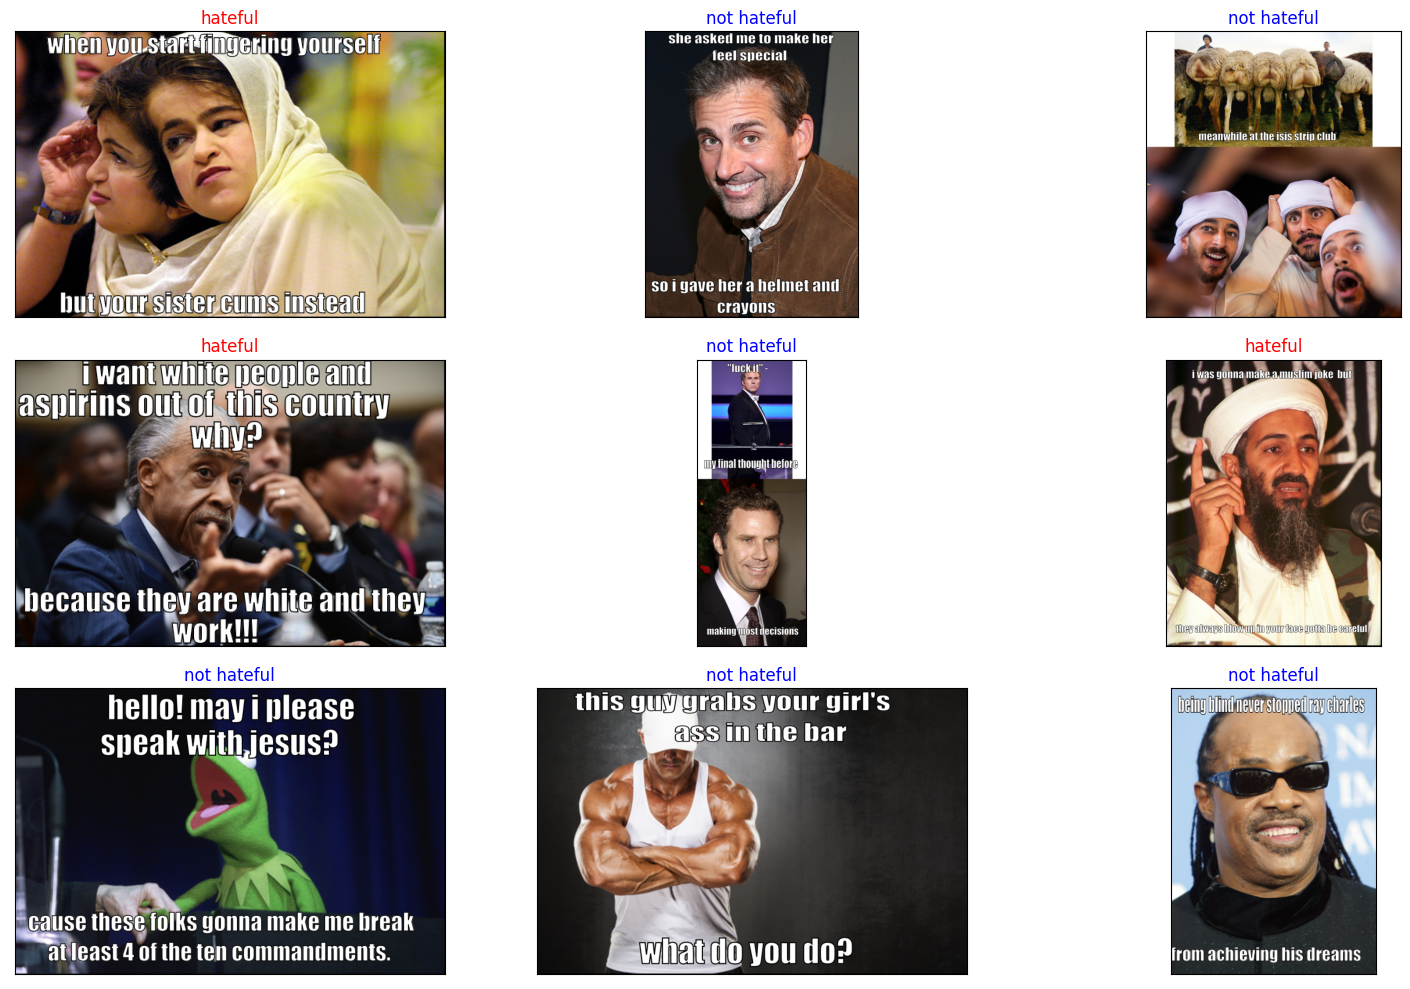

In [61]:
hm_dataset = HMDataset(
    images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None
)

plt.figure(figsize=(16, 10))

label_map = {1: "hateful", 0: "not hateful"}

for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):
    image, text, label = hm_dataset[idx]

    plt.subplot(3, 3, i + 1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label.item()], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


In [62]:
import torch.nn as nn
import torch.nn.functional as F


class HMMLP(nn.Module):
    def __init__(
        self,
        n_in=512 * 2,
        n_out=1,
    ) -> None:
        super().__init__()

        self.fc1 = nn.Linear(n_in, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, n_out)

    def forward(self, x):

        # x = self.fc1(x)
        x = F.dropout(F.relu(self.fc1(x)), p=0.3)
        x = F.dropout(F.relu(self.fc2(x)), p=0.3)
        x = F.dropout(F.relu(self.fc3(x)), p=0.2)
        x = self.fc4(x)

        return x


In [63]:
batch_size = 64


def text_preprocess(text):
    return clip.tokenize(text, truncate=True)

def get_dataloaders(get_source_data=True, data="train"):
    data_path_map = {
        "train": "train_updated.jsonl",
        "test": "test_unseen.jsonl",
        "val": "dev_unseen.jsonl"
    }
    if get_source_data:
        features_path_ = None
        # test_features_path = None
        # val_features_path = None

    else:
        features_path_ = os.path.join(features_path,data)
        # test_features_path = os.path.join(features_path, "test")
        # val_features_path = os.path.join(features_path, "val")

    hm_dataset = HMDataset(
        images_path,
        f"{annotations_path}/train_updated.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path_=features_path,
    )
    # hm_test_dataset = HMDataset(
    #     images_path,
    #     f"{annotations_path}/test_unseen.jsonl",
    #     image_transform=preprocess,
    #     text_transform=text_preprocess,
    #     features_path=test_features_path,
    # )
    # hm_val_dataset = HMDataset(
    #     images_path,
    #     f"{annotations_path}/dev_unseen.jsonl",
    #     image_transform=preprocess,
    #     text_transform=text_preprocess,
    #     features_path=val_features_path,
    # )

    dataloader = DataLoader(hm_dataset, batch_size=batch_size, shuffle=True)
    # test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True)
    # val_dataloader = DataLoader(hm_val_dataset, batch_size=batch_size, shuffle=True)

    return dataloader, get_source_data


In [64]:
# train_dataloader, test_dataloader, val_dataloader = get_dataloaders(False)


In [65]:
train_dataloader, _ = get_dataloaders()
data = next(iter(train_dataloader))

In [66]:
images, texts, labels = data
images.shape, texts.shape, labels.shape


(torch.Size([64, 3, 336, 336]), torch.Size([64, 1, 77]), torch.Size([64]))

In [67]:
net = HMMLP(n_in=1536)
images, texts, labels = data
images = images.to(device)
texts = texts.to(device)
labels = labels.to(device).float()

with torch.no_grad():
    images = model.encode_image(images)
    texts = model.encode_text(texts.squeeze())


In [68]:
images.shape, texts.shape, labels.shape

(torch.Size([64, 768]), torch.Size([64, 768]), torch.Size([64]))

In [69]:
net = net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer.zero_grad()

In [70]:
fused = torch.hstack((images, texts))
fused.requires_grad


False

In [71]:
fused.requires_grad_()
fused.requires_grad


True

In [72]:
output = net(fused.float())


In [73]:
output.shape, labels.shape


(torch.Size([64, 1]), torch.Size([64]))

In [74]:
labels.squeeze()


tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0')

In [75]:
output.squeeze(), labels.squeeze()


(tensor([0.1797, 0.1769, 0.2124, 0.1745, 0.1594, 0.1278, 0.1782, 0.1980, 0.1620,
         0.2087, 0.1334, 0.2157, 0.2386, 0.2082, 0.1748, 0.1728, 0.1694, 0.2202,
         0.2632, 0.1957, 0.1477, 0.1630, 0.1882, 0.2005, 0.1544, 0.1500, 0.1727,
         0.2032, 0.1479, 0.1909, 0.1742, 0.2050, 0.2043, 0.1721, 0.1855, 0.1251,
         0.2358, 0.1622, 0.1503, 0.1149, 0.2098, 0.1797, 0.1890, 0.1469, 0.1834,
         0.2057, 0.1717, 0.1995, 0.2199, 0.1798, 0.2228, 0.2105, 0.2024, 0.1762,
         0.2042, 0.1881, 0.1535, 0.1651, 0.2278, 0.1804, 0.1907, 0.1899, 0.1393,
         0.2032], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0'))

In [76]:
o = output.squeeze().round()


In [77]:
sum(o == labels)


tensor(36, device='cuda:0')

In [78]:
loss = criterion(output.squeeze(), labels.squeeze())
loss.backward()
optimizer.step()

In [79]:
# net = HMMLP(n_in=fused.shape[1]+fused.shape[1]//2)
net = HMMLP(n_in=589824)
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

epochs = 10
print_every = 50
image_features = torch.Tensor()
text_features = torch.Tensor()
label_features = torch.Tensor()
# labels_train = torch.Tensor()
# fused_images_texts_features_val = torch.Tensor()
# labels_val = torch.Tensor()
train_data_from_source = False

for epoch in range(epochs):
    train_dataloader, train_data_from_source = get_dataloaders(get_source_data=train_data_from_source)
    
    running_loss = 0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        if train_data_from_source:
            with torch.no_grad():
                images = model.encode_image(
                    images
                )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
                texts = model.encode_text(
                    texts.squeeze()
                )  # input_dim: batch_size x 77; output_dim: batch_size x 512

            # images = images / images.norm(dim=1, keepdim=True)
            # texts = texts / texts.norm(dim=1, keepdim=True)
        
        if epoch == 0 and train_data_from_source:
            image_features = torch.cat((image_features, images.cpu().clone().detach()))
            text_features = torch.cat((text_features, texts.cpu().clone().detach()))
            label_features = torch.cat((label_features, labels.cpu().clone().detach()))

        # fused_images_texts = torch.hstack((images, texts, (images+texts)/torch.tensor(2)))
        # fused_images_texts = fused_images_texts / fused_images_texts.norm(dim=1, keepdim=True)
        fused_images_texts = torch.bmm(images.unsqueeze(dim=2), texts.unsqueeze(dim=1))
        fused_images_texts = fused_images_texts.view((fused_images_texts.size(0),-1))

        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        optimizer.zero_grad()

        # Forward pass on the fused data

        output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        # Compute gradient
        loss.backward()
        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i % print_every == (print_every - 1):

            print(
                f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/print_every:.5f}"
            )
            running_loss = 0.0

    if epoch == 0 and train_data_from_source:
        torch.save(
            image_features, os.path.join(features_path, "train", "image_features.pt")
        )
        torch.save(
            text_features, os.path.join(features_path, "train", "text_features.pt")
        )
        torch.save(
            label_features, os.path.join(features_path, "train", "label_features.pt")
        )

    ## Switch to eval mode
    net.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    image_features = torch.Tensor()
    text_features = torch.Tensor()
    label_features = torch.Tensor()

    val_data_from_source = True
    val_dataloader, val_data_from_source = get_dataloaders(get_source_data=val_data_from_source, data="val")
    for i, data in enumerate(tqdm(val_dataloader), 0):

        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        if val_data_from_source:
            with torch.no_grad():
                images = model.encode_image(
                    images
                )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
                texts = model.encode_text(
                    texts.squeeze()
                )  # input_dim: batch_size x 77; output_dim: batch_size x 512
            
            # images = images / images.norm(dim=1, keepdim=True)
            # texts = texts / texts.norm(dim=1, keepdim=True)

        if epoch == 0 and val_data_from_source:
            image_features = torch.cat((image_features, images.cpu().clone().detach()))
            text_features = torch.cat((text_features, texts.cpu().clone().detach()))
            label_features = torch.cat((label_features, labels.cpu().clone().detach()))

        # fused_images_texts = torch.hstack((images, texts, (images+texts)/torch.tensor(2)))
        # fused_images_texts = fused_images_texts / fused_images_texts.norm(dim=1, keepdim=True)
        fused_images_texts = torch.bmm(images.unsqueeze(dim=2), texts.unsqueeze(dim=1))
        fused_images_texts = fused_images_texts.view((fused_images_texts.size(0),-1))

        # fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        with torch.no_grad():
            output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        running_loss += loss.item()

        correct_preds += sum(torch.sigmoid(output).squeeze().round() == labels)
        total_preds += len(labels)
        auroc = BinaryAUROC(pos_label=1)
        auroc_score = auroc(output, labels.int())

    print(
        f"[Epoch {epoch +1}, step {i+1:3d}] val loss: {running_loss/i+1:.5f} accuracy: {correct_preds/total_preds} auroc: {auroc_score}"
    )

    if epoch == 0 and val_data_from_source:
        torch.save(
            image_features, os.path.join(features_path, "val", "image_features.pt")
        )
        torch.save(
            text_features, os.path.join(features_path, "val", "text_features.pt")
        )
        torch.save(
            label_features, os.path.join(features_path, "val", "label_features.pt")
        )
    net.train()


print("Finished Training!")

UnboundLocalError: local variable 'features_path' referenced before assignment

In [ ]:
test_features_path = os.path.join(features_path, "test")
test_dataloader, test_data_from_source = get_dataloaders(get_source_data=False, data="test")
hm_test_dataset = HMDataset(
        images_path,
        f"{annotations_path}/test_unseen.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=test_features_path,
    )

# test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True)
len(hm_test_dataset)

0

In [ ]:
torch.load(f"{test_features_path}/image_features.pt")

tensor([])

In [ ]:
running_loss = 0.0
correct_preds = 0
total_preds = 0
epoch = 0

image_features = torch.Tensor()
text_features = torch.Tensor()
label_features = torch.Tensor()
test_data_from_source=True
test_dataloader, test_data_from_source = get_dataloaders(get_source_data=test_data_from_source, data="test")
for i, data in enumerate(tqdm(test_dataloader), 0):

    images, texts, labels = data
    images = images.to(device)
    texts = texts.to(device)
    labels = labels.float().squeeze().to(device)

    if test_data_from_source:
        with torch.no_grad():
            images = model.encode_image(
                images
            )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(
                texts.squeeze()
            )  # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        # images = images / images.norm(dim=1, keepdim=True)
        # texts = texts / texts.norm(dim=1, keepdim=True)

    if epoch == 0 and test_data_from_source:
        image_features = torch.cat((image_features, images.cpu().clone().detach()))
        text_features = torch.cat((text_features, texts.cpu().clone().detach()))
        label_features = torch.cat((label_features, labels.cpu().clone().detach()))

    # fused_images_texts = torch.hstack((images, texts, (images+texts)/torch.tensor(2)))
    # fused_images_texts = fused_images_texts / fused_images_texts.norm(dim=1, keepdim=True)
    fused_images_texts = torch.bmm(images.unsqueeze(dim=2), texts.unsqueeze(dim=1))
    fused_images_texts = fused_images_texts.view((fused_images_texts.size(0),-1))

    # fused_images_texts.requires_grad_()
    fused_images_texts = fused_images_texts.float()

    with torch.no_grad():
        output = net(fused_images_texts)

    loss = criterion(output.squeeze(), labels)

    running_loss += loss.item()

    correct_preds += sum(torch.sigmoid(output).squeeze().round() == labels)
    total_preds += len(labels)
    auroc = BinaryAUROC(pos_label=1)
    auroc_score = auroc(output, labels.int())

print(
    f"[Epoch {epoch +1}, step {i+1:3d}] test loss: {running_loss/i+1:.5f} accuracy: {correct_preds/total_preds} auroc: {auroc_score}"
)

# if epoch == 0 and data_from_source:
torch.save(
    image_features, os.path.join(features_path, "test", "image_features.pt")
)
torch.save(
    text_features, os.path.join(features_path, "test", "text_features.pt")
)
torch.save(
    label_features, os.path.join(features_path, "test", "label_features.pt")
)


print("Finished Training!")

  3%|▎         | 1/32 [00:06<03:36,  6.99s/it]

torch.Size([64, 768]) torch.Size([64, 768])


  6%|▋         | 2/32 [00:10<02:23,  4.80s/it]

torch.Size([64, 768]) torch.Size([64, 768])


  9%|▉         | 3/32 [00:13<02:02,  4.22s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 12%|█▎        | 4/32 [00:19<02:12,  4.73s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 16%|█▌        | 5/32 [00:23<02:03,  4.58s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 19%|█▉        | 6/32 [00:29<02:12,  5.11s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 22%|██▏       | 7/32 [00:34<02:01,  4.88s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 25%|██▌       | 8/32 [00:36<01:35,  3.97s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 28%|██▊       | 9/32 [00:39<01:23,  3.64s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 31%|███▏      | 10/32 [00:42<01:20,  3.64s/it]

torch.Size([64, 768]) torch.Size([64, 768])


 34%|███▍      | 11/32 [00:45<01:12,  3.43s/it]

torch.Size([64, 768]) torch.Size([64, 768])


In [1]:
fused_images_texts = torch.bmm(images.unsqueeze(dim=2), texts.unsqueeze(dim=1))
fused_images_texts = fused_images_texts.view((fused_images_texts.size(0),-1)).shape
# texts.view((texts.size(0),-1))

NameError: name 'torch' is not defined

In [45]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f/1000**2

1864.881152

In [46]:
torch.cuda.get_device_name(), torch.cuda.mem_get_info()

('Quadro RTX 6000', (19315818496, 25373442048))

In [48]:
25373442048/1000**3

25.373442048